In [8]:
import matplotlib.pyplot as plt
import numpy as np
def llamarDatos (nombreArchivo):
    import os
    import pandas as pd
    serie=os.path.join('Data',nombreArchivo+'.csv')
    serie_pd = pd.read_csv(serie, sep = ',',encoding='latin-1')
    return serie_pd

def datos(nombreArchivo,Fuerza):
    data=llamarDatos(nombreArchivo)
    RPM=data['Motor Electrical Speed (RPM)'][~np.isnan(data[Fuerza])]
    fuerza=data[Fuerza][~np.isnan(data[Fuerza])]
    time=data['Time (s)'][~np.isnan(data[Fuerza])]
    return time,RPM,fuerza

def plots(nombreArchivo):
    thrust=datos(nombreArchivo,'Thrust (N)' )[2]
    torque=datos(nombreArchivo,'Torque (NÂ·m)')[2]
    
    timeTh=datos(nombreArchivo,'Thrust (N)' )[0]
    timeT=datos(nombreArchivo,'Torque (NÂ·m)')[0]
    
    RPMTh=datos(nombreArchivo,'Thrust (N)' )[1]
    RPMT=datos(nombreArchivo,'Torque (NÂ·m)')[1]
    
    plt.figure(1)#RPM vs Thrust
    plt.plot(RPMTh,thrust,'b^')
    plt.xlabel('RPM')
    plt.ylabel('Thrust [N]')
    plt.savefig(nombreArchivo+'_Thrust_vs_RPM')
    plt.show
    
    plt.figure(2)#RPM vs Torque
    plt.plot(RPMT,torque,'b^')
    plt.xlabel('RPM')
    plt.ylabel('Torque [Nm]')
    plt.savefig(nombreArchivo+'_Torque_vs_RPM')
    plt.show
    
    plt.figure(3)#Torque vs Time
    plt.plot(timeT,torque,'b-')
    plt.xlabel('Time')
    plt.ylabel('Torque [Nm]')
    plt.savefig(nombreArchivo+'_Torque_vs_Time')
    plt.show
    
    plt.figure(4)#Thrust vs Time
    plt.plot(timeTh,thrust,'b-')
    plt.xlabel('Time')
    plt.ylabel('Thrust [N]')
    plt.savefig(nombreArchivo+'_Thrust_vs_Time')
    plt.show
    
    plt.figure(5)#Torque vs Time
    plt.plot(timeTh,RPMTh,'b-')
    plt.xlabel('Time')
    plt.ylabel('RPM')
    plt.savefig(nombreArchivo+'_RPM_vs_Time')
    plt.show
    return

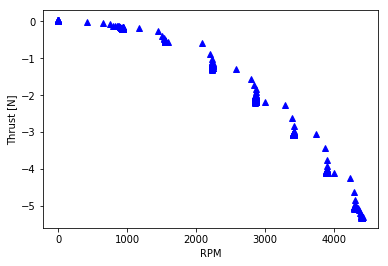

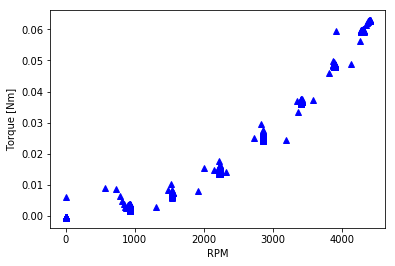

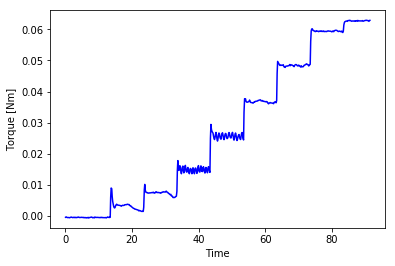

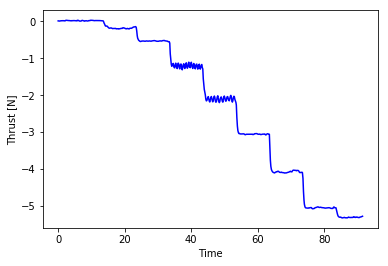

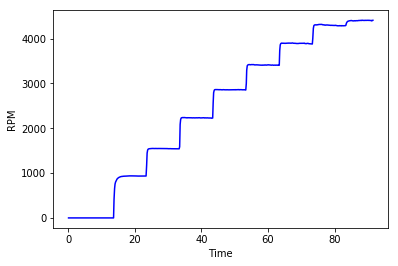

In [9]:
plots('Log_2018-03-08_161928')